In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow.keras.layers as layers
from keras import backend as K
import keras
import tensorflow as tf

import sklearn
from sklearn import metrics
from sklearn.feature_extraction import image
from tqdm import tqdm

import sys
import os
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
import training_modules
import evaluation_modules

/bg/fast/env_wiegels-r/mambaforge/envs/tf_CNN_sev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# whole area of SEVIRI and lowres RADKLIM for testing
# prepared SEVIRI
ds_input_test = xr.open_dataset('../data/input.nc')
# prepared radar data (lowres RADKLIM YW)
ds_target_test = xr.open_dataset('../data/target.nc').rainfall_amount
ds_target = xr.open_dataset('../data/target.nc')

In [3]:
bi_threshold = 0.05 # (mm/15min)

# from DL_data_analysis: excludes outlier
min_temp = 202.758
max_temp = 317.1550 
min_bright = 0.000000
max_bright = 101.4570

In [4]:
# create binary target
ds_target_test = training_modules.create_bi_img(
    np.asarray(ds_target_test), 
    threshold=bi_threshold)

(584, 180, 252, 8)


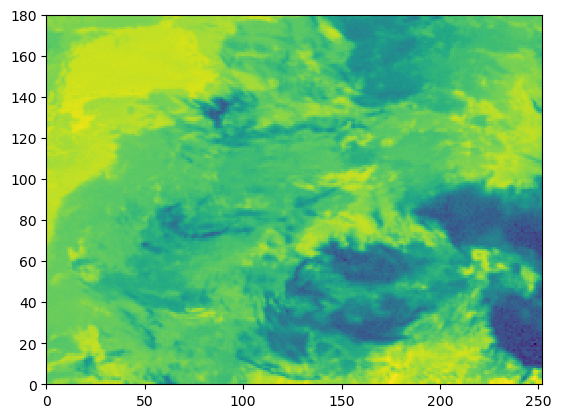

In [5]:
# Normalize input
x_test = np.asarray(training_modules.normalize_test(ds_input_test, min_temp = min_temp, max_temp = max_temp, 
                                                    min_bright = min_bright, max_bright = max_bright))

In [6]:
# Transformation to tensor for DL Model
yw_test = tf.convert_to_tensor(ds_target_test, dtype=tf.int8)
test_0, test_1, test_2, test_3, test_4, test_5, test_6, test_7 = training_modules.to_tensor(x_test)

2024-01-04 17:47:12.471348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 17:47:14.012409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19811 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


## Evaluate the sev_CNN model

In [7]:
# open saved model
model = keras.models.load_model("../model/sev_CNN", custom_objects = {'binary_crossentropy': tf.keras.metrics.binary_crossentropy, 'recall':tf.keras.metrics.Recall, 
                                                                          'accuracy': tf.keras.metrics.BinaryAccuracy, 'get_f1': training_modules.get_f1, 'matthews_correlation': training_modules.matthews_correlation,
                                                                          'false_neg_rate': training_modules.false_neg_rate,'true_neg_rate': training_modules.true_neg_rate, 'mse': tf.keras.metrics.MeanSquaredError})

In [8]:
test_prediction = model.predict([test_1, test_3, test_5, test_6], batch_size=128)

2024-01-04 17:47:17.993924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-01-04 17:47:19.185789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8800
2024-01-04 17:47:19.385514: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 17:47:19.386585: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 17:47:19.386613: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2024-01-04 17:47:19.387233: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 17:47:19.387277: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

In [26]:
# Calculate scores for test data
pred_bi = training_modules.create_bi_img(test_prediction, threshold=0.5)
diff = np.asarray(pred_bi).reshape(pred_bi.shape[0], pred_bi.shape[1], pred_bi.shape[2])-np.asarray(yw_test).reshape(yw_test.shape[0], yw_test.shape[1], yw_test.shape[2])

# Target threshold
target_th = 0.05

# throw out any nans
target_arr = ds_target_test
target_bi = training_modules.create_bi_img(target_arr, threshold=target_th)
target_bi_flat = target_bi.flatten()
target_bi_clean = target_bi_flat[~np.isnan(target_bi_flat)]
pred_bi_clean = pred_bi.flatten()[~np.isnan(target_bi_flat)]
# calculate scores
oa, mcc, sens, spec, tn, fp, fn, tp = evaluation_modules.confusion_matrix(y_pred=pred_bi_clean, y_true=target_bi_clean)
mse = sklearn.metrics.mean_squared_error(y_true=target_bi_clean, y_pred= pred_bi_clean)
df_results = pd.DataFrame({'threshold': [0.05] , 'acc': [oa], 'mcc': [mcc], 'sens': [sens], 'spec': [spec], 'mse':[mse],
                                   'TP (k)': [int(tp/1000)], 'FP(k)': [int(fp/1000)], 'FN(k)': [int(fn/1000)], 'TN(k)': [int(tn/1000)]})
df_results

,threshold,acc,mcc,sens,spec,mse,TP (k),FP(k),FN(k),TN(k)
0,0.05,0.913159,0.540742,0.720884,0.930035,0.086841,853,943,330,12545


2021-06-26T11:30:00.000000000


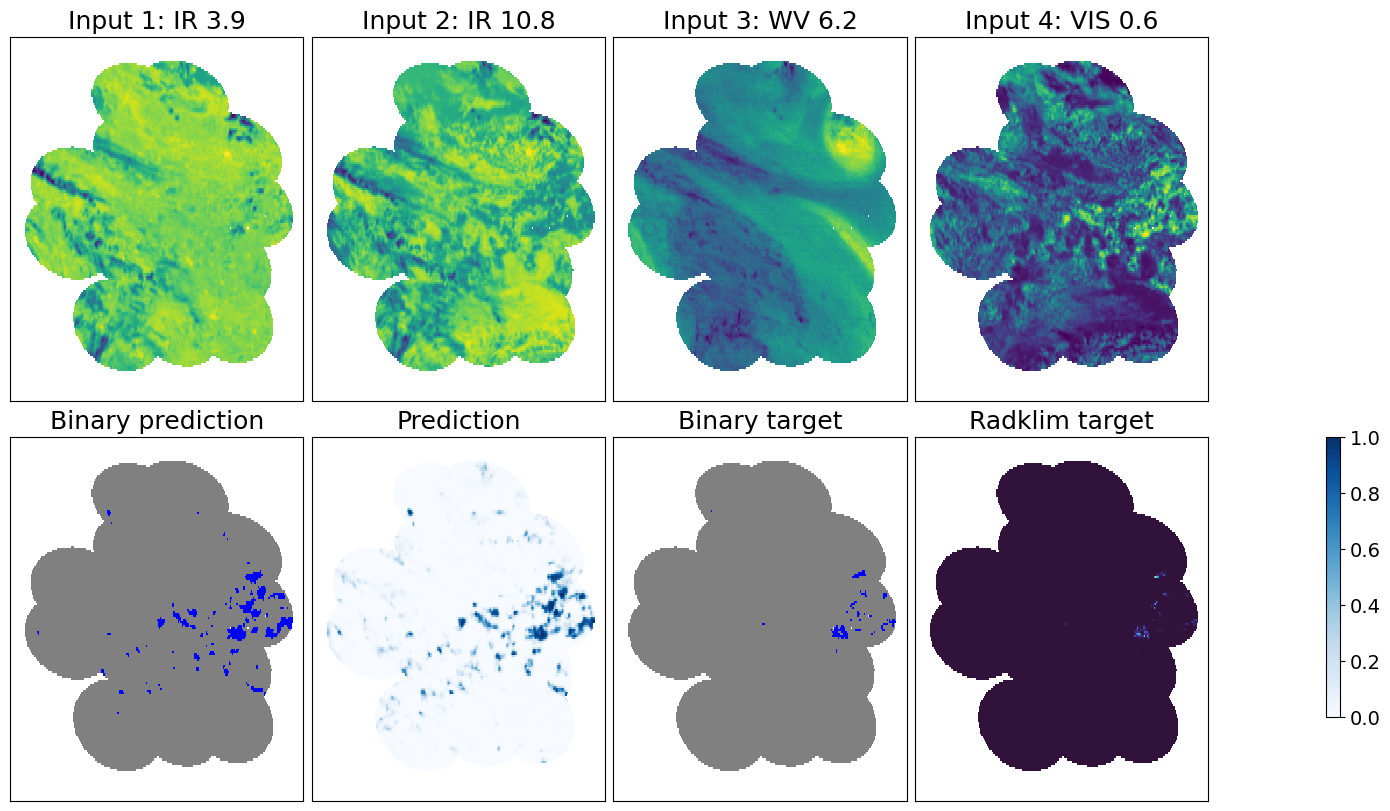

In [27]:
# check out results of test area
import matplotlib.colors as colors


cmap_bi = (colors.ListedColormap(['grey', 'blue']))
cmap_diff = (colors.ListedColormap(['red', 'green', 'blue']))
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 8), constrained_layout=True)
i = 150

# create masks for displaying only germany extent as from RADKLIM
d = ds_target_test[i]
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)
timestep = ds_input_test.isel(time=i).time.values
# Input Channels
ax[0,0].pcolormesh(mask_img(np.asarray(test_1[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])))
ax[0,1].pcolormesh(mask_img(np.asarray(test_3[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])))
ax[0,2].pcolormesh(mask_img(np.asarray(test_6[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])))
ax[0,3].pcolormesh(mask_img(np.asarray(test_5[i]).reshape(np.asarray(test_5[i]).shape[0], np.asarray(test_5[i]).shape[1])))

ax[0,0].set_title('Input 1: IR 3.9', fontsize=18)
ax[0,1].set_title('Input 2: IR 10.8', fontsize=18)
ax[0,2].set_title('Input 3: WV 6.2', fontsize=18)
ax[0,3].set_title('Input 4: VIS 0.6', fontsize=18)

# Predictions
ax[1,0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
im1 = ax[1,1].pcolormesh(mask_img(test_prediction[i].reshape(test_prediction.shape[1], test_prediction.shape[2])), vmin=0, vmax=1, cmap='Blues')
# RADLKLIM Target
ax[1,2].pcolormesh(mask_img(np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
im = ax[1,3].pcolormesh(ds_target_test[i], cmap='turbo')

#im2 = ax[4].pcolormesh(np.asarray(diff[i]).reshape(diff.shape[1], diff.shape[2]), vmin=-1, vmax=1, cmap=cmap_diff)
ax[1,0].set_title('Binary prediction', fontsize=18)
ax[1,1].set_title('Prediction', fontsize=18)
ax[1,2].set_title('Binary target', fontsize=18)
ax[1,3].set_title('Radklim target', fontsize=18)


#ax[4].set_title('Difference', fontsize=18)
#ax[5].pcolormesh(np.asarray(test_0618_6[i]).reshape(test_0618_6.shape[1], test_0618_6.shape[2]))
cbar1 = plt.colorbar(im1, ax=ax[1,4])
#cbar1.set_label('[%]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)
# cbar = plt.colorbar(im,ax=ax[1,4])
# cbar.set_label('[mm/15min]', fontsize=14)
# cbar.ax.tick_params(labelsize=14)
# cbar2 = plt.colorbar(im2, ticks=[-1, 0, 1], cmap=cmap_diff,
#     ax=ax[4],
#     extend='both',
#     spacing='proportional')
# cbar2.ax.set_yticklabels(['FN', 'TP/TN', 'FP'], fontsize=14)
print(timestep)
fig.delaxes(ax.flatten()[4])
fig.delaxes(ax.flatten()[9])
for i in range(0, 4):
    for j in range(0,2):
        ax[j,i].tick_params('both', labelleft=False, labelbottom=False, left=False, bottom=False)
#plt.subplots_adjust(wspace=0.0,hspace=0.0)
#plt.tight_layout()
plt.show()

## Results for Thesis

2021-06-30T13:15:00.000000000


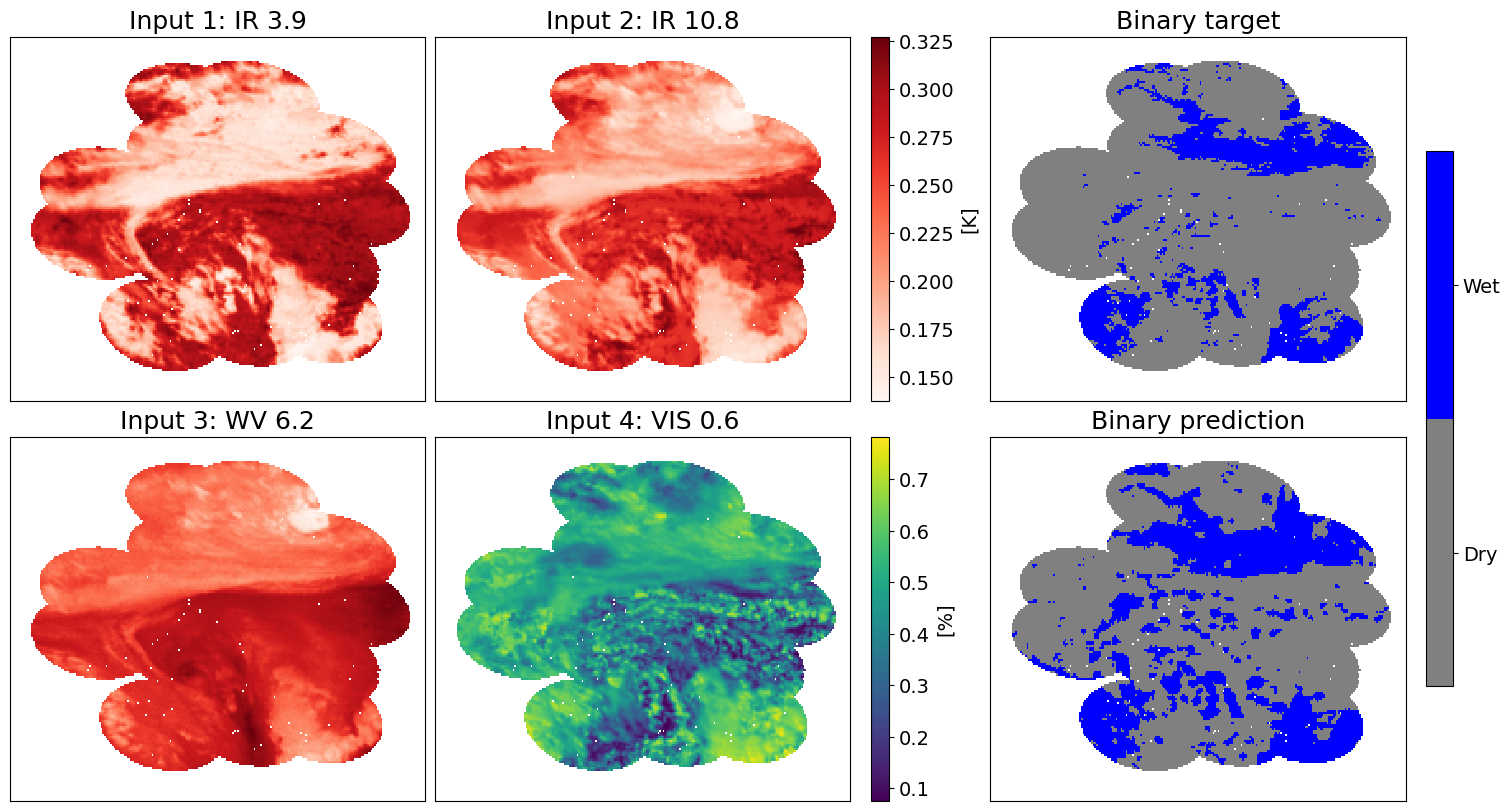

In [28]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_bi = (colors.ListedColormap(['grey', 'blue']))
cmap_diff = (colors.ListedColormap(['grey', 'red', 'cyan']))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)
#i = 0 #--> selected for night bias in area and issue with scattered rainfall
i = 540
#i=350# --> good day example?
#i= 250 # --> good day example?

# create masks for displaying only germany extent as from RADKLIM
d = ds_target_test[10]
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)
timestep = ds_input_test.isel(time=i).time.values
# Input Channels
im = ax[0,0].pcolormesh(mask_img(np.asarray(test_1[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])), cmap='Reds')
im = ax[0,1].pcolormesh(mask_img(np.asarray(test_3[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])), cmap='Reds')
im = ax[1,0].pcolormesh(mask_img(np.asarray(test_6[i]).reshape(np.asarray(test_1[i]).shape[0], np.asarray(test_1[i]).shape[1])), cmap='Reds')
im5 = ax[1,1].pcolormesh(mask_img(np.asarray(test_5[i]).reshape(np.asarray(test_5[i]).shape[0], np.asarray(test_5[i]).shape[1])))

ax[0,0].set_title('Input 1: IR 3.9', fontsize=18)
ax[0,1].set_title('Input 2: IR 10.8', fontsize=18)
ax[1,0].set_title('Input 3: WV 6.2', fontsize=18)
ax[1,1].set_title('Input 4: VIS 0.6', fontsize=18)

# Predictions
im_bi = ax[1,2].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)

#im1 = ax[2,0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])+np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=2, cmap=cmap_diff)
# RADLKLIM Target
im_bi = ax[0,2].pcolormesh(mask_img(np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
#im = ax[1,3].pcolormesh(np.asarray(ds_target_test.values)[i], cmap='turbo')

# title
ax[1,2].set_title('Binary prediction', fontsize=18)
#ax[1,0].set_title('Prediction', fontsize=18)
ax[0,2].set_title('Binary target', fontsize=18)
#ax[1,3].set_title('Radklim target', fontsize=18)


print(timestep)


for i in range(0, 3):
    for j in range(0,2):
        ax[j,i].tick_params('both', labelleft=False, labelbottom=False, left=False, bottom=False)
#plt.subplots_adjust(wspace=0.0,hspace=0.0)
#plt.tight_layout()
#cbar
cbar = plt.colorbar(im_bi, ticks=[0.25, 0.75], cmap=cmap_bi,
                     ax=ax[:2,2], spacing='proportional', shrink=0.7)
cbar.ax.set_yticklabels(['Dry', 'Wet'], fontsize=14)
cbar = plt.colorbar(im, ax=ax[0,1])
cbar.set_label('[K]', fontsize=14,)
cbar.ax.tick_params(  labelsize=14)
cbar5 = plt.colorbar(im5, ax=ax[1,1])
cbar5.set_label('[%]', fontsize=14)
cbar5.ax.tick_params( labelsize=14)
plt.show()

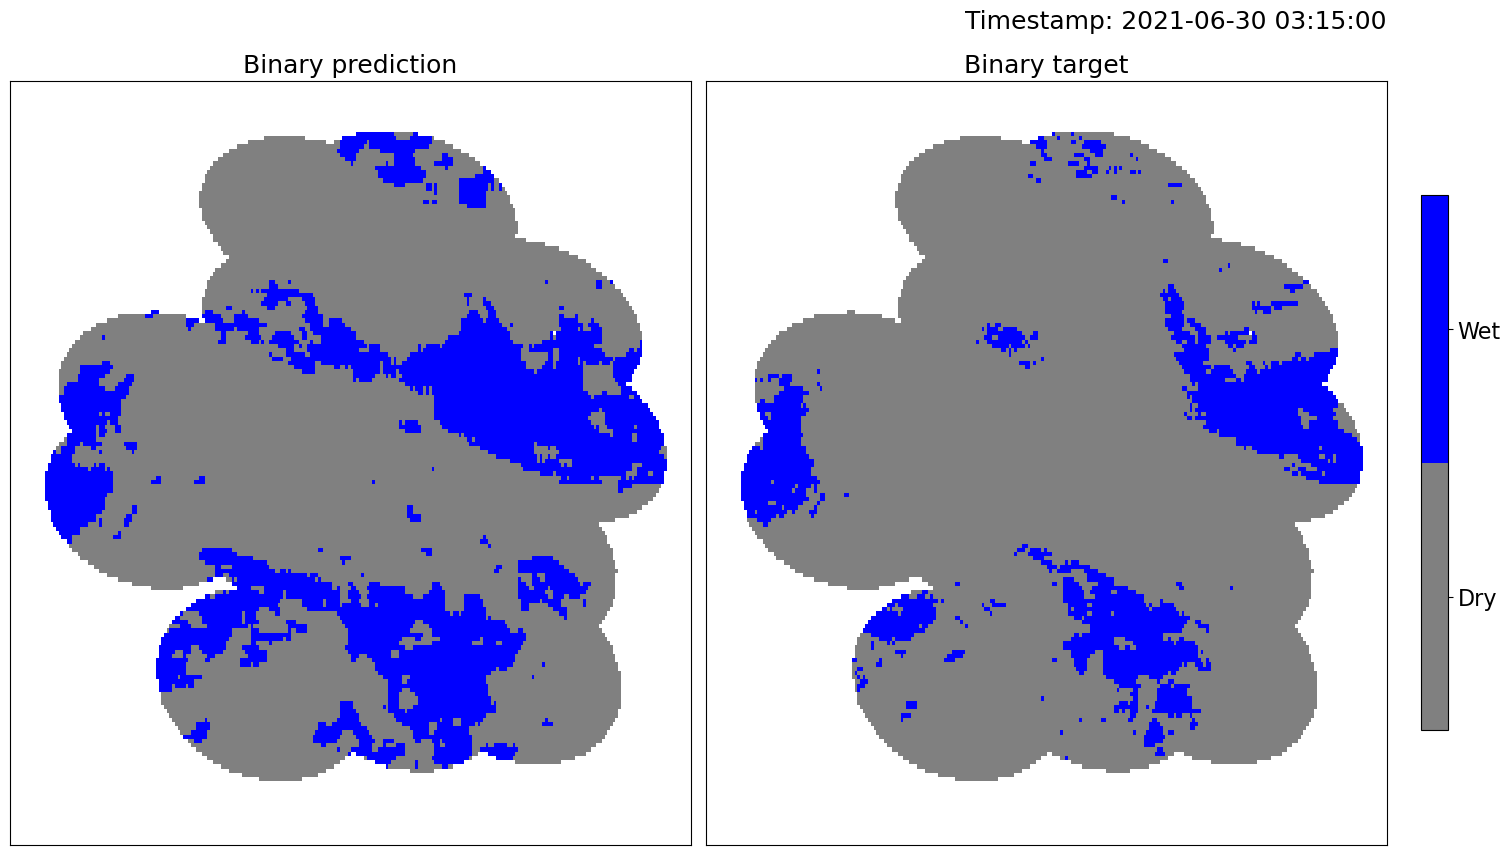

In [29]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_bi = (colors.ListedColormap(['grey', 'blue']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
i=500

# create masks for displaying only germany extent as from RADKLIM
d = ds_target_test[100]
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)
timestep = ds_input_test.isel(time=i).time.values

# Predictions
im_bi = ax[0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)
#im1 = ax[2,0].pcolormesh(mask_img(pred_bi[i].reshape(pred_bi.shape[1], pred_bi.shape[2])+np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=2, cmap=cmap_diff)
# RADLKLIM Target
im_bi = ax[1].pcolormesh(mask_img(np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])), vmin=0, vmax=1, cmap=cmap_bi)

fig.suptitle('Timestamp: '+str(pd.Timestamp(timestep)), fontsize=18, x=0.78, y=1.05)
# title
ax[0].set_title('Binary prediction', fontsize=18)
#ax[1,0].set_title('Prediction', fontsize=18)
ax[1].set_title('Binary target', fontsize=18)
#ax[1,3].set_title('Radklim target', fontsize=18)

for i in range(0, 2):
    ax[i].tick_params('both', labelleft=False, labelbottom=False, left=False, bottom=False)

cbar = plt.colorbar(im_bi, ticks=[0.25, 0.75], cmap=cmap_bi,
                     ax=ax[1], spacing='proportional', shrink=0.7)
cbar.ax.set_yticklabels(['Dry', 'Wet'], fontsize=16)

plt.show()

In [960]:
# Save Figure?
#fig.savefig('images/gif_wetdry/080.png', bbox_inches='tight')

2021-06-25T10:30:00.000000000


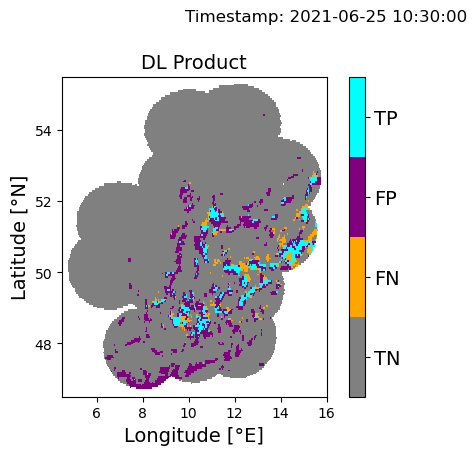

In [30]:
i = 50


timestep = ds_input_test.isel(time=i).time.values
print(timestep)
pred_arr = np.asarray(pred_bi[i]).reshape(pred_bi.shape[1], pred_bi.shape[2])
target_img = np.asarray(yw_test[i]).reshape(yw_test.shape[1], yw_test.shape[2])

cmap_diff = (colors.ListedColormap(['grey', 'orange', 'purple', 'cyan']))

# mask
mask = np.zeros(d.shape, dtype=bool)
ones = np.ones(d.shape)
mask = np.where(d>=0, mask, ones)
def mask_img(img):
    return np.ma.array(img, mask=mask)

# define TN/TP/FN/FP
def tfpn_img(pred_img, target_img):
    pred_target_tp = np.where(np.logical_and(pred_img==1, target_img==1), 4, np.nan)
    pred_target_fp = np.where(np.logical_and(pred_img==1, target_img==0), 3, np.nan)
    pred_target_fn = np.where(np.logical_and(pred_img==0, target_img==1), 2, np.nan)
    pred_target_tn = np.where(np.logical_and(pred_img==0, target_img==0), 1, np.nan)
    return pred_target_tp, pred_target_fp, pred_target_fn, pred_target_tn

pred_tp, pred_fp, pred_fn, pred_tn = tfpn_img(pred_arr, target_img)



# display all in one image
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), constrained_layout=True)
#prediction
im = ax.pcolormesh(ds_target.LON.values, ds_target.LAT.values, mask_img(pred_tp), cmap=cmap_diff, vmin=1, vmax=4)
im = ax.pcolormesh(ds_target.LON.values, ds_target.LAT.values, mask_img(pred_fp), cmap=cmap_diff, vmin=1, vmax=4)
im = ax.pcolormesh(ds_target.LON.values, ds_target.LAT.values, mask_img(pred_fn), cmap=cmap_diff, vmin=1, vmax=4)
im = ax.pcolormesh(ds_target.LON.values, ds_target.LAT.values, mask_img(pred_tn), cmap=cmap_diff, vmin=1, vmax=4)
fig.suptitle('Timestamp: '+str(pd.Timestamp(timestep)), fontsize=12, x=0.8, y=1.1)

# title
ax.set_title('DL Product', fontsize=14)

fig.suptitle('Timestamp: '+str(pd.Timestamp(timestep)), fontsize=12, x=0.8, y=1.1)
# axis settings
xticks = np.arange(4, 18, 2)
yticks = np.arange(46, 58, 2)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel('Longitude [°E]', fontsize=14)
ax.set_xlim(4.5, 16)
ax.set_ylim(46.5, 55.5)
ax.set_ylabel('Latitude [°N]', fontsize=14)

#cbar
cbar = plt.colorbar(im, ticks=[1, 2, 3, 4], cmap=cmap_diff,
                     ax=ax, values=[1,2,3,4])
cbar.ax.set_yticklabels(['TN', 'FN', 'FP', 'TP'], fontsize=14)
plt.show()